In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## statsmodels의 Logit을 이용한 로지스틱 회귀분석

- https://www.statsmodels.org/stable/api.html#generalized-linear-models

### 예제데이터 : titanic datasets

#### 데이터 로드

In [3]:
titanic = sns.load_dataset('titanic')

In [4]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


#### 분석 데이터 추출

In [7]:
titanic.columns[:7]

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare'], dtype='object')

In [9]:
df = titanic[titanic.columns[:7]]
df.shape

(891, 7)

#### EDA & 전처리

In [15]:
def data_describe(df):
    desc = df.describe().T
    skew = []
    kurtosis = []
    null = []
    for ftr in desc.index:
        skew.append(df[ftr].skew())
        kurtosis.append(df[ftr].kurtosis())
        null.append(df[ftr].isna().sum())
    desc['skewness'] = skew
    desc['kurtosis'] = kurtosis
    desc['n_null'] = null
    return desc

#### 기술통계량

In [16]:
data_describe(df)

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,n_null
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000,0.478523,-1.775005,0
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000,-0.630548,-1.280015,0
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000,0.389108,0.178274,177
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000,3.695352,17.880420,0
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000,2.749117,9.778125,0
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292,4.787317,33.398141,0


- 시각화

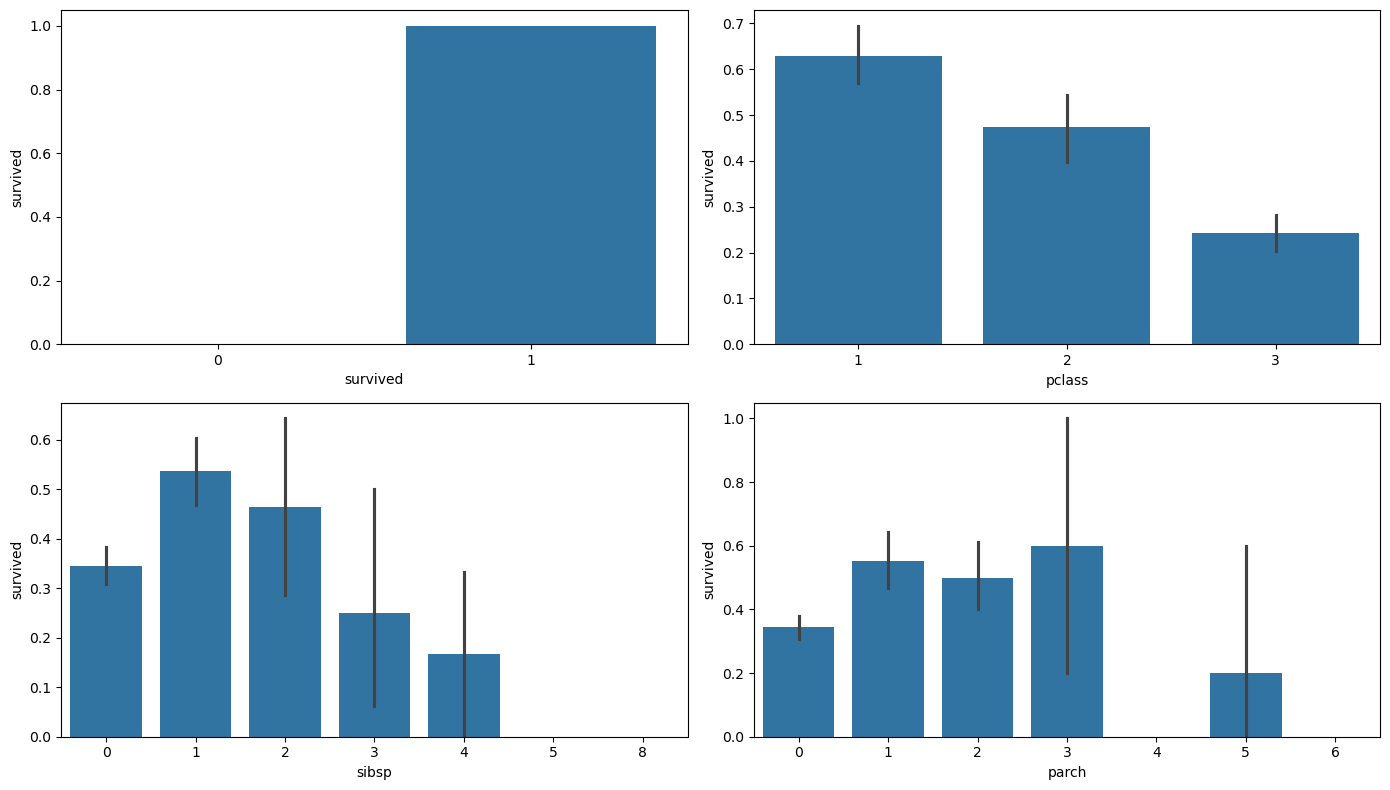

In [21]:
bar_ftrs = df.select_dtypes(include= 'int')

fig, ax = plt.subplots(figsize=(14,8), nrows=2, ncols=2)
for i, ftr in enumerate(bar_ftrs):
    row, col = i//2, i%2
    sns.barplot(data=df, x= ftr, y='survived', ax=ax[row][col])
plt.tight_layout()
plt.show()

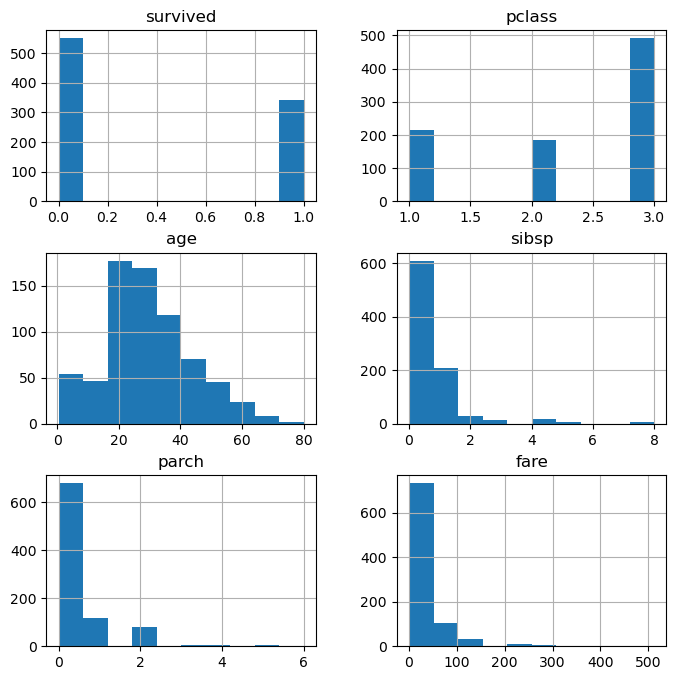

In [22]:
df.hist(figsize=(8,8))
plt.show()

#### 데이터 전처리 : 결측치 처리

In [23]:
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
dtype: int64

In [24]:
df.dropna(inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  714 non-null    int64  
 1   pclass    714 non-null    int64  
 2   sex       714 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     714 non-null    int64  
 5   parch     714 non-null    int64  
 6   fare      714 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 44.6+ KB


#### 원핫인코딩

In [37]:
df_ohe = pd.get_dummies(df, columns=['pclass','sex'], dtype='int',drop_first=True)
df_ohe.head()

,survived,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male
0,0,22.0,1,0,7.2500,0,1,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,1,0
3,1,35.0,1,0,53.1000,0,0,0
4,0,35.0,0,0,8.0500,0,1,1


### sm.Logit()으로 로지스틱 회귀분석

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### 상수항 추가

In [38]:
ftr_names = df_ohe.columns.difference(['survived'])
x = df_ohe[ftr_names]
x_ = sm.add_constant(x, has_constant='add')
y = df_ohe.survived
x_.shape, y.shape

((714, 8), (714,))

#### 로지스틱 회귀모형 생성

In [40]:
model = sm.Logit(y, x_)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.445221
         Iterations 6


#### 회귀모형 적합 결과

In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      706
Method:                           MLE   Df Model:                            7
Date:                Tue, 04 Jun 2024   Pseudo R-squ.:                  0.3408
Time:                        14:19:05   Log-Likelihood:                -317.89
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 4.361e-67
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1800      0.503      8.303      0.000       3.193       5.167
age           -0.0442      0.008     -5.343      0.000      -0.060      -0.028
fare           0.0020      0.003      0.797      0.425      -0.003       0.007
parch         -0.0613      0.123     -0.498      0.618      -0.302       0.180
pclass_2      -1.2925      0.322     -4.017      0.000      -1.923      -0.662
pclass_3      -2.5011      0.339     -7.383      0.000      -3.165      -1.837
sex_male      -2.6375      0.220    -11.984      0.000      -3.069      -2.206
sibsp         -0.3768      0.127     -2.956      0.003      -0.627      -0.127
==============================================================================
"""

- 추정된 로지스틱 회귀식

$$ logit(X) = age + fare + parch + ... +sibsp $$

- Logit함수의 계수 추정값

In [43]:
# coef
result.params

const       4.179995
age        -0.044159
fare        0.002043
parch      -0.061268
pclass_2   -1.292538
pclass_3   -2.501069
sex_male   -2.637451
sibsp      -0.376847
dtype: float64

- Logit함수의 계수값에 대한 신뢰구간 (2.5%, 97.5%)

In [45]:
# 신뢰구간 값 추출
result.conf_int()

,0,1
const,3.193310,5.166680
age,-0.060356,-0.027961
fare,-0.002981,0.007068
parch,-0.302202,0.179665
pclass_2,-1.923167,-0.661908
pclass_3,-3.164995,-1.837143
sex_male,-3.068795,-2.206108
sibsp,-0.626708,-0.126985


- Odds :  exp(Logit)

In [46]:
np.exp(result.params)

const       65.365514
age          0.956802
fare         1.002045
parch        0.940571
pclass_2     0.274573
pclass_3     0.081997
sex_male     0.071543
sibsp        0.686021
dtype: float64

#### 로지스틱 회귀분석 결과 해석 : Logit와 Odds

- age는 값이 높아질수록 생존확률은 낮아짐
    - Logit : age가 1살이 증가할 때 생존일 Logit이 -0.0442 단위 증가
    - Odds : age가 1살이 증가할 때 생존할 확률이 0.9568배($ e^{-0.0442} $) 증가
    
- sex_male(남성)인 경우 생존확률이 낮아짐
    - Logit : sex_male이 1단위 증가할 때 생존일  Logit이 -2.6375 단위 증가
    - Odds : sex_male이 1단위 증가할 때 생존일 확률이 0.0715배($ e^{-2.6375} $) 증가

#### 예측

- Age가 10, 30, 50 인 경우 생존확률 예측하기

In [47]:
df_ohe.mean()

survived     0.406162
age         29.699118
sibsp        0.512605
parch        0.431373
fare        34.694514
pclass_2     0.242297
pclass_3     0.497199
sex_male     0.634454
dtype: float64

In [48]:
ages = [5,10,30,50,60]
means = df_ohe.mean()
pred_df = pd.DataFrame({'age':ages, 'sibsp':means.sibsp, 'parch':means.parch,'fare':means.fare,
              'pclass_2':means.pclass_2,'pclass_3':means.pclass_3,
             'sex_male':means.sex_male, 'const': result.params.const})
pred_df

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,const
0,5,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995
1,10,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995
2,30,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995
3,50,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995
4,60,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995


In [49]:
# predict => 생존확률
pred_df['predict'] = result.predict(pred_df)
pred_df

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,const,predict
0,5,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995,0.999999
1,10,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995,1.000000
2,30,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995,1.000000
3,50,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995,1.000000
4,60,0.512605,0.431373,34.694514,0.242297,0.497199,0.634454,4.179995,1.000000


---------

### 사이킷런의 LogisticRegression을 이용한 분석

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

**주요 매개변수**
- penalty : 규제 유형, 'l1', 'l2', 'elasticnet', 'none' (dafault : 'l2')
- C : 규제 강도 조절 alpha의 역수, C값이 작을수록 규제강도가 큼
- solver: 최적화
    - lbfgs: 기본값, 메모리공간 절약, CPU 코어 수가 많은 경우 최적화 병렬로 수행할 수 있음
    - liblinear: 사이킷런 0.21버전까지의 디폴트값, 다차원이고 작은데이터셋에서 효과적으로 동작, 국소최적화 이슈가 있음
    - lewton-dg: 정교한 최적화 가능, 대용량의 데이터에서 속도가 많이 느리다.
    - sag: 경사하강법 적용, 대용량의 데이터에서 빠르게 최적화
    - saga: sag와 유사한 방식. L1정규화가 가능

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, roc_curve, classification_report

# 이진 분류 모델의 성능지표
def get_eval_score(test_y, pred, pred_proba_c1= None):
    
    # 혼동행렬(오차행렬)
    confusion = confusion_matrix(test_y, pred)
    # 정밀도(precision)
    precision = precision_score(test_y, pred)
    # 정확도(accuracy_score)
    accuracy = accuracy_score(test_y, pred)
    # 재현율(recall)
    recall = recall_score(test_y, pred)
    # F1 score
    f1 = f1_score(test_y, pred)
    # G-measure -> 정밀도와 재현율의 기하평균 -> np.sqrt(recall_socre*precision_score)
    g = np.sqrt(recall_score(test_y, pred)*precision_score(test_y, pred))

    print(f'confusion matrix:\n{confusion}\n')
    print(f'accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}',end=' ')
    print(f'F1: {f1:.4f}, G: {g:.4f}')
    if pred_proba_c1 is not None:
        auc = roc_auc_score(test_y, pred_proba_c1)
        print(f'auc: {auc:.4f}')

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=156)

lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
pred = lr_clf.predict(x_test)
pred_proba = lr_clf.predict_proba(x_test)[:,1]
get_eval_score(y_test, pred, pred_proba)

confusion matrix:
[[110  13]
 [ 28  64]]

accuracy: 0.8093, precision: 0.8312, recall: 0.6957 F1: 0.7574, G: 0.7604
auc: 0.8826


In [54]:
# solver = 'liblinear'
lr_clf2 = LogisticRegression(solver='liblinear')
lr_clf2.fit(x_train, y_train)
pred2 = lr_clf2.predict(x_test)
pred_proba2 = lr_clf2.predict_proba(x_test)[:,1]
get_eval_score(y_test, pred2, pred_proba2)

confusion matrix:
[[111  12]
 [ 29  63]]

accuracy: 0.8093, precision: 0.8400, recall: 0.6848 F1: 0.7545, G: 0.7584
auc: 0.8821


**로지스틱회귀에서 규제를 적용한 최적의 모델 검증**

In [59]:
from sklearn.model_selection import GridSearchCV

lr_clf3 = LogisticRegression() 

# C: 1/alpha -> 값이 낮을수록 규제강도가 커짐
params ={'penalty':['l2','l1','none'],
        'C':[0.01, 0.1, 1, 5, 10]}

grid_cv = GridSearchCV(lr_clf3, param_grid = params, scoring= 'accuracy',cv=3)
grid_cv.fit(x_train, y_train)
print(f'Best Params: {grid_cv.best_params_}')
print(f'Best Score: {grid_cv.best_score_:.4f}')

Best Params: {'C': 1, 'penalty': 'l2'}
Best Score: 0.8016


In [60]:
best_pred = grid_cv.best_estimator_.predict(x_test)
get_eval_score(y_test, best_pred)

confusion matrix:
[[110  13]
 [ 28  64]]

accuracy: 0.8093, precision: 0.8312, recall: 0.6957 F1: 0.7574, G: 0.7604


-------------------------------------